In [6]:
import numpy  as np
import pandas as pd
import gc
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns

from IPython.display import display

In [80]:
df = pd.read_csv('~/Documents/data/nyc-taxi-trip-duration/train.csv')

_TARGET = 'trip_duration'
sample  = df[['id', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', _TARGET]].sample(12345)

X = sample[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
y = sample[[_TARGET]]

# linear

## teoria

encontrar conjunto de parâmetros $w$ que melhor aproxime a superfície $\hat{y}(w,x)$ ao conjunto de pontos $x$ 

$$ \hat{y}(w,x) = w^T \phi(x) $$

para generalizacao e conexao com a abordagem probabilistica, se

$$ y \sim p(y | \theta, x) = \mathcal{N}(y | w^T \phi(x), \sigma^2(x)) $$

usando bayes

$$ \text{posterior} = \frac{ \text{likelihood} \times \text{prior} }{ \text{evidence} } \qquad \left[ p(y|x,h) = \frac{ p(x|y,h) \times p(y|h) }{ p(x|h) } = \frac{ p(x|y,h) \times p(y|h) }{ \sum_{y^{\prime}}p(x|y^{\prime},h)p(y^{\prime}|h) } \right]$$

é possível reescrever $y$ como

$$ p(y | \theta, x) = \frac{p(\theta| y, x)p(y | x)}{p(\theta | x)} \longrightarrow \boxed{ p(y | \theta, x) = \frac{p(\theta| y, x)p(y | x)}{p(\theta | x)} }$$

então

$$ p(\theta| y, x) = \frac{p(y|\theta,x)p(\theta | x)}{p(y | x)} \propto p(y|\theta,x)p(\theta | x)$$

nessa forma a regressao fica definida como um modelo discriminativo ([1](https://stats.stackexchange.com/questions/285891/regression-vs-classification-and-generative-vs-discriminative),[2](https://stats.stackexchange.com/questions/12421/generative-vs-discriminative?rq=1)) e uma forma de estimar o parâmetro $\theta$ é via [markov chain monte carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)

- - -

aplicar [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) na log-verossimilhança

$$
\begin{aligned}
\mathcal{L}(\theta) &= log \sum_i p(y_i | x_i, \theta) = -\frac{1}{2\sigma^2} \\                      &= \sum_i (y_i - w^T\phi(x_i))^2 - \frac{N}{2}log(2 \pi \sigma^2)
\end{aligned}
$$ 

leva a

$$ \boxed{\hat{w} = ((X^T X)^{-1} ) X^Ty} $$

onde $X^T X$ é a matriz $\sum_i x_i x_i^T$

- - -

**pros**

+ solucao exata para estimativa de parâmetro $\therefore$ barato computacionalmente

**cons**

+ underfitting devido a outliers; _solucao_: trocar a verossimilhança por uma student ou laplace que possuem caudas mais pesadas de modo que outliers passam a perturbar menos a curva
+ overfitting; _solucao_: trocar mle por map e atribuir uma prior para os parametros

- - -

**relacionado**

+ [what is autocorrelation? @ zedstatistics](https://www.youtube.com/watch?v=UFvDSX3jsYg); pattern on residuals
    + common causes: 1, omitted variables; 2, incorrect functional form
    + [durbin–watson statistic](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic), teste estatistico sobre os erros residuais, varia de 0 a 4, quanto mais perto de 2 menos autocorrelacionado
    + [breusch–godfrey test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Godfrey_test), regressão segundária sobre cada desvio
    + endogenous effect <- omitted variable affecting observed variables
    + [linear difference equation](https://en.wikipedia.org/wiki/Linear_difference_equation)

## codigo

mae:  570.0926184334847
dw :  2.0038864359788686


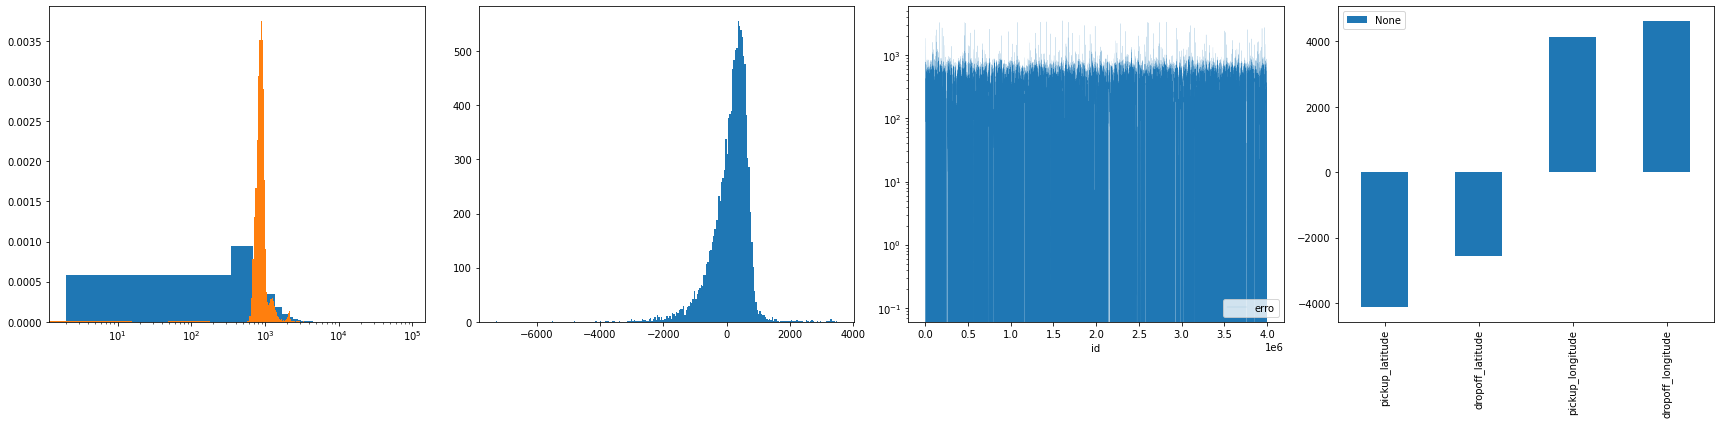

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics      import mean_absolute_error
from statsmodels.stats    import stattools


# modelo
linreg = LinearRegression(fit_intercept=True)
linreg.fit(X, y)


# analise
analise = sample[['id', _TARGET]].rename(columns={_TARGET:'y'})
analise['id']   = analise['id'].str.slice(2).astype(np.int64)
analise['yhat'] = linreg.predict(X)
analise['erro'] = analise['yhat']-analise['y']


# performance
print( "mae: ", mean_absolute_error( analise['y'], analise['yhat'] ) )
print( "dw : ", stattools.durbin_watson(analise['erro']) )


# visualizacao
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(ncols=4, nrows=1, figsize=(24,6))

ax1.hist(analise['y']    , bins=250, density=True, label='true')
ax1.hist(analise['yhat'] , bins=250, density=True, label='pred')
ax1.set_xscale('log')

ax2.hist( analise[abs(analise['erro'])<1e4]['erro'], bins=250 )

analise.sort_values(by='id').plot(x='id', y='erro', ax=ax3, linewidth=0.1)
ax3.set_yscale('log')

pd.Series(linreg.coef_.flatten(), X.columns.values.flatten()).sort_values().plot(kind='bar', ax=ax4)

plt.tight_layout()
plt.legend();

# polynomial

## teoria

$$\square$$

## codigo

mae:  474.19354751172847
dw :  2.004273581157971


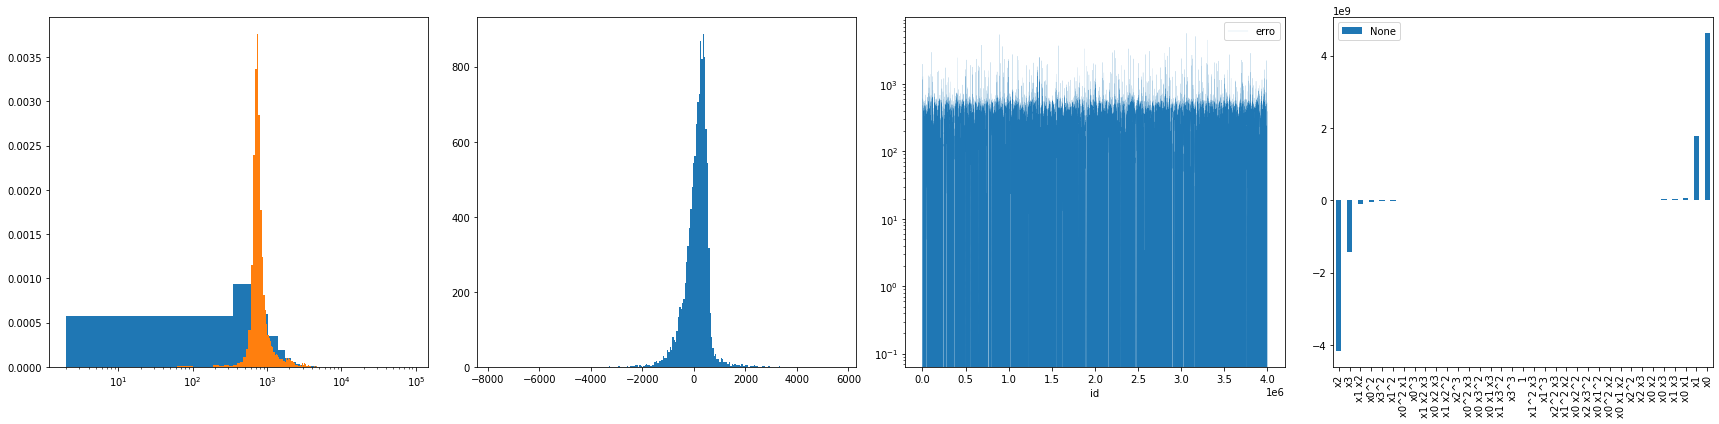

In [83]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model  import LinearRegression
from sklearn.metrics       import mean_absolute_error
from statsmodels.stats     import stattools


# modelo
d = 3
polyreg = PolynomialFeatures(degree=d)
x_poly  = polyreg.fit_transform(X)

linreg_p  = LinearRegression(fit_intercept=True)
linreg_p.fit(x_poly,  y)


# analise
analise = sample[['id', _TARGET]].rename(columns={_TARGET:'y'})
analise['id']   = analise['id'].str.slice(2).astype(np.int64)
analise['yhat'] = linreg_p.predict(x_poly)
analise['erro'] = analise['yhat']-analise['y']


# performance
print( "mae: ", mean_absolute_error( analise['y'], analise['yhat'] ) )
print( "dw : ", stattools.durbin_watson(analise['erro']) )


# visualizacao
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(ncols=4, nrows=1, figsize=(24,6))

ax1.hist(analise['y']    , bins=250, density=True, label='true')
ax1.hist(analise['yhat'] , bins=250, density=True, label='pred')
ax1.set_xscale('log')

ax2.hist( analise[abs(analise['erro'])<1e4]['erro'], bins=250 )

analise.sort_values(by='id').plot(x='id', y='erro', ax=ax3, linewidth=0.1)
ax3.set_yscale('log')

pd.Series(linreg_p.coef_.flatten(), polyreg.get_feature_names()).sort_values().plot(kind='bar', ax=ax4)

plt.tight_layout()
plt.legend();

# ridge, lasso, elastic-net

## teoria

_ridge_ 

$$ \underset{w}{argmin}\left( |y-wx|^2 + \lambda|w|^2 \right) $$

tambem possui solucao exata

$$ \boxed{\hat{w} = (\lambda I +  X^T X)^{-1} ) X^Ty} $$

**pros**

+ possui solucao exata
+ controle de complexidade do modelo via parametro de regularizacao $\therefore$ controle de overfitting.

- - -

_lasso_

$$ \underset{w}{argmin}\left( |y-wx|^2 + \lambda|w| \right) $$

produz solucoes esparsas ([1](https://stats.stackexchange.com/questions/267322/difference-between-missing-data-and-sparse-data-in-machine-learning-algorithms))

- - -

_elastic-net_

$$ \underset{w}{argmin}\left[ \left( \frac{1}{2N}|y - wx|^2 \right) + \left( \alpha  \ell_1  |w|_1 \right) + \frac{1}{2}\alpha (1 - \ell_1) |w|^2 \right] $$

com $\alpha = a+b$ e $\ell_1 = \frac{a}{a+b}$

- - -

**relacionado**
+ comparacoes entre os três metodos de regularizacao ([1](https://blog.alexlenail.me/what-is-the-difference-between-ridge-regression-the-lasso-and-elasticnet-ec19c71c9028),[2](http://www.sthda.com/english/articles/37-model-selection-essentials-in-r/153-penalized-regression-essentials-ridge-lasso-elastic-net/),[3](https://stats.stackexchange.com/questions/93181/ridge-lasso-and-elastic-net))
+ pode ser estabelecida relacao entre _ridge regression_ e _pca regression_ ([1](https://stats.stackexchange.com/questions/81395/relationship-between-ridge-regression-and-pca-regression),[2](https://nirpyresearch.com/pcr-vs-ridge-regression-nir-data-python/)); na pratica _ridge regression_ tende a ter acuracia preditiva maior e _pca regression_ atua na reducao de dimensionalidade

## codigo

0.0010046463989966537
mae:  570.0934062961911
dw :  2.0038864706403463


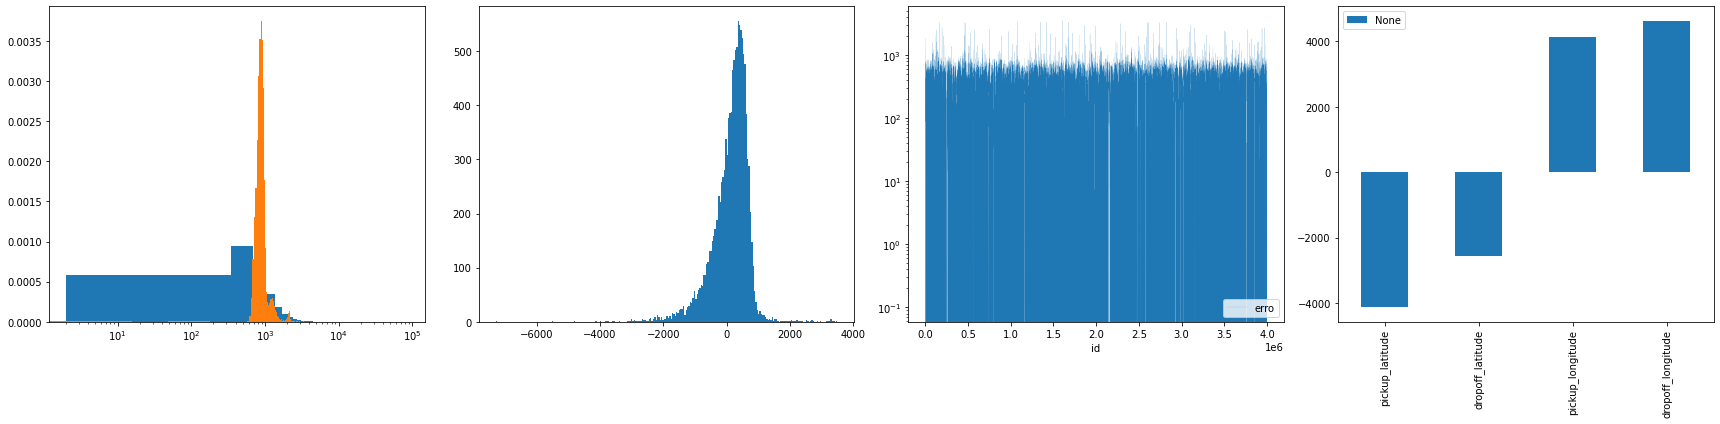

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model    import Ridge
from sklearn.metrics         import mean_absolute_error
from statsmodels.stats       import stattools


# modelo
ridge_cv   = GridSearchCV(Ridge(fit_intercept=True), {'alpha': [2.37**i for i in range(-8, 8)]}, scoring='neg_mean_absolute_error', cv=5)
ridge_cv.fit(X, y)
print(ridge_cv.best_params_['alpha'])

ridreg = Ridge( alpha=ridge_cv.best_params_['alpha'], fit_intercept=True )
ridreg.fit(X, y)


# analise
analise = sample[['id', _TARGET]].rename(columns={_TARGET:'y'})
analise['id']   = analise['id'].str.slice(2).astype(np.int64)
analise['yhat'] = ridreg.predict(X)
analise['erro'] = analise['yhat']-analise['y']


# performance
print( "mae: ", mean_absolute_error( analise['y'], analise['yhat'] ) )
print( "dw : ", stattools.durbin_watson(analise['erro']) )


# visualizacao
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(ncols=4, nrows=1, figsize=(24,6))

ax1.hist(analise['y']    , bins=250, density=True, label='true')
ax1.hist(analise['yhat'] , bins=250, density=True, label='pred')
ax1.set_xscale('log')

ax2.hist( analise[abs(analise['erro'])<1e4]['erro'], bins=250 )

analise.sort_values(by='id').plot(x='id', y='erro', ax=ax3, linewidth=0.1)
ax3.set_yscale('log')

pd.Series(ridreg.coef_.flatten(), X.columns.values.flatten()).sort_values().plot(kind='bar', ax=ax4)

plt.tight_layout()
plt.legend();